=== PART 2: DATA OVERVIEW ===
Summary Table (first 20 rows):
         sample  total_count  population  count  percentage
0   sample00000        93214      b_cell  10908   11.702105
1   sample00000        93214  cd8_t_cell  24440   26.219237
2   sample00000        93214  cd4_t_cell  20491   21.982749
3   sample00000        93214     nk_cell  13864   14.873302
4   sample00000        93214    monocyte  23511   25.222606
5   sample00001       100824      b_cell   6777    6.721614
6   sample00001       100824  cd8_t_cell  19407   19.248393
7   sample00001       100824  cd4_t_cell  33459   33.185551
8   sample00001       100824     nk_cell  18170   18.021503
9   sample00001       100824    monocyte  23011   22.822939
10  sample00002        92822      b_cell   9794   10.551378
11  sample00002        92822  cd8_t_cell  22940   24.713969
12  sample00002        92822  cd4_t_cell  24274   26.151128
13  sample00002        92822     nk_cell  17482   18.833897
14  sample00002        92822    monocyt

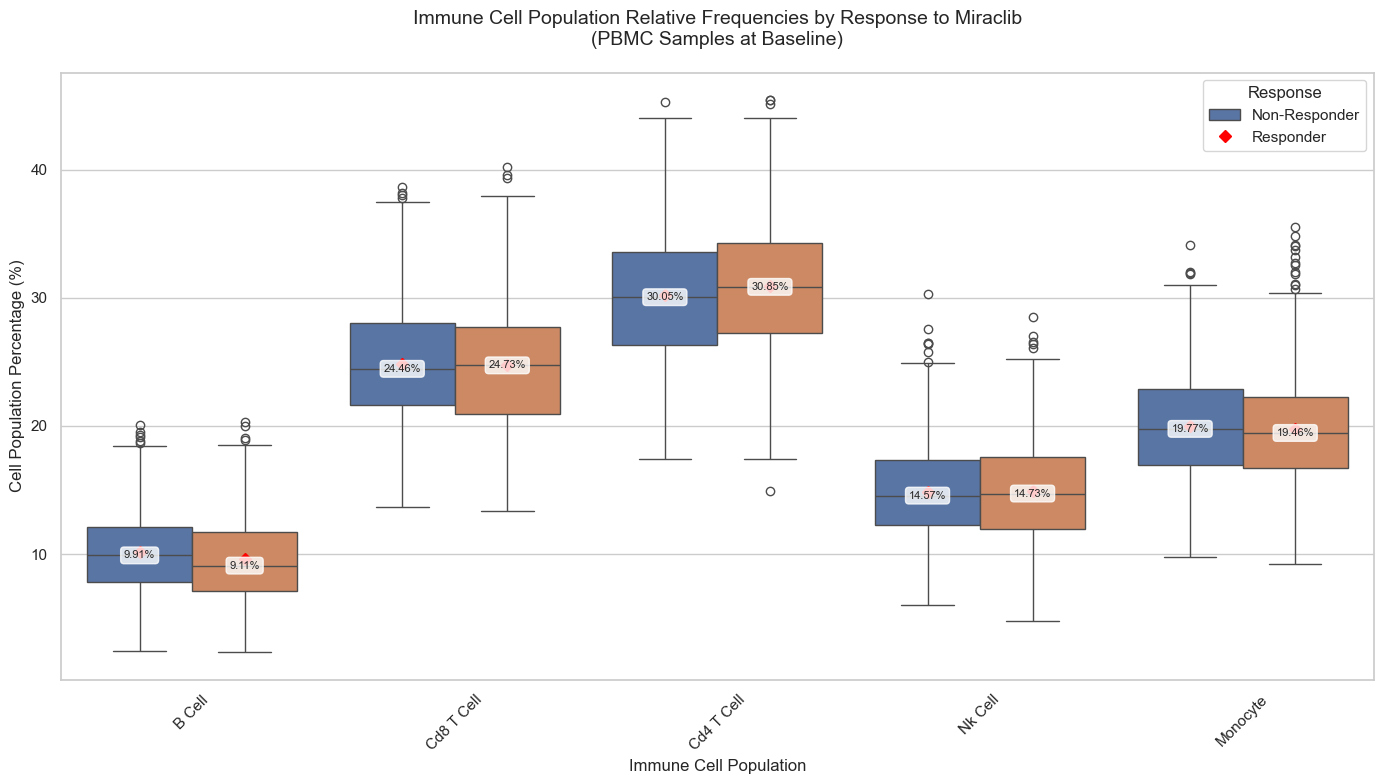


=== STATISTICAL TESTING ===
Mann-Whitney U test results (comparing responders vs non-responders):
----------------------------------------------------------------------
B Cell          | Responders:   9.11% | Non-Responders:   9.91% | p-value: 0.0024 | *SIGNIFICANT*
Cd8 T Cell      | Responders:  24.73% | Non-Responders:  24.46% | p-value: 0.7884 | Not significant
Cd4 T Cell      | Responders:  30.85% | Non-Responders:  30.05% | p-value: 0.0110 | *SIGNIFICANT*
Nk Cell         | Responders:  14.73% | Non-Responders:  14.57% | p-value: 0.6080 | Not significant
Monocyte        | Responders:  19.46% | Non-Responders:  19.77% | p-value: 0.1670 | Not significant

=== SUMMARY TABLE ===
Population Median_Responders Median_Non_Responders P_Value Significant
    B Cell             9.11%                 9.91%  0.0024         Yes
Cd8 T Cell            24.73%                24.46%  0.7884          No
Cd4 T Cell            30.85%                30.05%  0.0110         Yes
   Nk Cell            14.73

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Read the data
df = pd.read_csv('/Users/kyleke/Downloads/teiko_dashboard/data/raw_csv/cell_count.csv')

# Define immune cell columns
immune_cols = ['b_cell', 'cd8_t_cell', 'cd4_t_cell', 'nk_cell', 'monocyte']

# PART 2: Initial Analysis - Data Overview
print("=== PART 2: DATA OVERVIEW ===")

# Calculate total count for each sample
df['total_count'] = df[immune_cols].sum(axis=1)

# Calculate percentages for each population
for col in immune_cols:
    df[f'{col}_percentage'] = (df[col] / df['total_count']) * 100

# Create summary table as specified
summary_rows = []
for idx, row in df.iterrows():
    for population in immune_cols:
        summary_rows.append({
            'sample': row['sample'],
            'total_count': row['total_count'],
            'population': population,
            'count': row[population],
            'percentage': row[f'{population}_percentage']
        })

summary_df = pd.DataFrame(summary_rows)
print("Summary Table (first 20 rows):")
print(summary_df.head(20))
print(f"\nTotal rows in summary table: {len(summary_df)}")

# PART 3: Statistical Analysis
print("\n=== PART 3: STATISTICAL ANALYSIS ===")

# Filter data for miraclib treatment, PBMC samples, baseline (time 0), with response data
filtered_df = df.query(
    "sample_type == 'PBMC' and "
    "response.notnull() and "
    "treatment == 'miraclib' and "
    "time_from_treatment_start == 14"
)

print(f"Filtered dataset size: {len(filtered_df)} samples")
print(f"Responders: {len(filtered_df.query('response == \"yes\"'))}")
print(f"Non-responders: {len(filtered_df.query('response == \"no\"'))}")

# Prepare data for visualization and statistics
percentage_cols = [f'{col}_percentage' for col in immune_cols]

# Create long format data for boxplot
long_df = filtered_df.melt(
    id_vars=['response'],
    value_vars=percentage_cols,
    var_name='Population',
    value_name='Percentage'
)

# Clean up population names for better labels
long_df['Population'] = (long_df['Population']
                        .str.replace('_percentage', '')
                        .str.replace('_', ' ')
                        .str.title())

# Create boxplot
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

ax = sns.boxplot(
    data=long_df,
    x='Population',
    y='Percentage',
    hue='response',
    showmeans=True,
    meanprops={"marker": "D", "markerfacecolor": "red", "markeredgecolor": "red"}
)

# Add median labels
for i, pop in enumerate(long_df['Population'].unique()):
    for j, resp in enumerate(['no', 'yes']):
        subset = long_df.query("Population == @pop and response == @resp")['Percentage']
        if not subset.empty:
            median = subset.median()
            # Position text boxes properly
            xpos = i - 0.2 + j * 0.4
            ax.text(
                xpos, median, f'{median:.2f}%',
                ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                fontsize=8
            )

plt.title("Immune Cell Population Relative Frequencies by Response to Miraclib\n(PBMC Samples at Baseline)", 
          fontsize=14, pad=20)
plt.ylabel("Cell Population Percentage (%)", fontsize=12)
plt.xlabel("Immune Cell Population", fontsize=12)
plt.legend(title='Response', labels=['Non-Responder', 'Responder'], loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistical Analysis - Compare responders vs non-responders
print("\n=== STATISTICAL TESTING ===")
print("Mann-Whitney U test results (comparing responders vs non-responders):")
print("-" * 70)

significant_populations = []
results_table = []

for col in percentage_cols:
    responders = filtered_df.query('response == "yes"')[col].dropna()
    non_responders = filtered_df.query('response == "no"')[col].dropna()
    
    if len(responders) > 0 and len(non_responders) > 0:
        # Perform Mann-Whitney U test (non-parametric)
        statistic, p_value = stats.mannwhitneyu(
            responders, non_responders, 
            alternative='two-sided'
        )
        
        # Calculate medians for comparison
        median_responders = responders.median()
        median_non_responders = non_responders.median()
        
        # Clean population name
        pop_name = col.replace('_percentage', '').replace('_', ' ').title()
        
        # Determine significance
        is_significant = p_value < 0.05
        if is_significant:
            significant_populations.append(pop_name)
        
        results_table.append({
            'Population': pop_name,
            'Median_Responders': f"{median_responders:.2f}%",
            'Median_Non_Responders': f"{median_non_responders:.2f}%",
            'P_Value': f"{p_value:.4f}",
            'Significant': 'Yes' if is_significant else 'No'
        })
        
        print(f"{pop_name:15} | Responders: {median_responders:6.2f}% | "
              f"Non-Responders: {median_non_responders:6.2f}% | "
              f"p-value: {p_value:.4f} | {'*SIGNIFICANT*' if is_significant else 'Not significant'}")

# Create results summary table
results_df = pd.DataFrame(results_table)
print(f"\n=== SUMMARY TABLE ===")
print(results_df.to_string(index=False))

# Summary of significant findings
print(f"\n=== CONCLUSIONS ===")
if significant_populations:
    print(f"Cell populations with significant differences between responders and non-responders:")
    for pop in significant_populations:
        print(f"  • {pop}")
    print(f"\nThese {len(significant_populations)} population(s) show statistically significant differences")
    print("and may be potential biomarkers for predicting treatment response to miraclib.")
else:
    print("No cell populations showed statistically significant differences between")
    print("responders and non-responders at the p < 0.05 level.")

print(f"\nNote: Analysis based on {len(filtered_df)} PBMC samples from patients receiving miraclib at baseline.")

In [20]:
import pandas as pd

# Assuming your DataFrame is named df
# Define the columns for immune cell populations
cell_columns = ['b_cell', 'cd8_t_cell', 'cd4_t_cell', 'nk_cell', 'monocyte']

# 1. Calculate total cell count
df['total_count'] = df[cell_columns].sum(axis=1)

# 2. Calculate relative frequencies for each cell type as percentage
for col in cell_columns:
    df[f'{col}_pct'] = (df[col] / df['total_count']) * 100

df.query("sample == 'sample00000'")

,project,subject,condition,age,sex,treatment,response,sample,sample_type,time_from_treatment_start,...,b_cell_percentage,cd8_t_cell_percentage,cd4_t_cell_percentage,nk_cell_percentage,monocyte_percentage,b_cell_pct,cd8_t_cell_pct,cd4_t_cell_pct,nk_cell_pct,monocyte_pct
0,prj1,sbj000,melanoma,57,M,miraclib,no,sample00000,PBMC,0,...,11.702105,26.219237,21.982749,14.873302,25.222606,11.702105,26.219237,21.982749,14.873302,25.222606


In [ ]:
import requests

base_url = 'http://127.0.0.1:8000'
treatment = "miraclib"
condition = "melanoma"
time_from_treatment_start = 0
sample_type = "PBMC"

response = requests.get(
    f"{base_url}/analysis_results/subset_analysis/{treatment}/{condition}/{time_from_treatment_start}/{sample_type}"
)

# Check and print the result
if response.status_code == 200:
    result = response.json()
    print(result)
else:
    print(f"Request failed with status {response.status_code}: {response.text}")

    {'samples_per_project': [{'project': 'prj1', 'sample_count': 384}, {'project': 'prj3', 'sample_count': 272}], 'subjects_by_response': [{'response': 'yes', 'subject_count': 331}, {'response': 'no', 'subject_count': 325}], 'subjects_by_sex': [{'sex': 'F', 'subject_count': 312}, {'sex': 'M', 'subject_count': 344}]}


{'samples_per_project': [{'project': 'prj1', 'sample_count': 384}, {'project': 'prj3', 'sample_count': 272}], 'subjects_by_response': [{'response': 'yes', 'subject_count': 331}, {'response': 'no', 'subject_count': 325}], 'subjects_by_sex': [{'sex': 'F', 'subject_count': 312}, {'sex': 'M', 'subject_count': 344}]}


In [90]:
response.json()

{'detail': 'Error fetching box plot statistics data: rest.model_rest.BoxPlotStatsResult() argument after ** must be a mapping, not quoted_name'}

In [44]:
pd.DataFrame(response.json()).query("time_from_treatment_start == 0").raw_p_value

1     0.083299
5     0.709608
8     0.619850
11    0.083299
12    0.631218
14    0.188133
21    0.709608
23    0.631218
28    0.619850
29    0.188133
Name: raw_p_value, dtype: float64

In [28]:
pd.DataFrame(response.json()).query("time_from_treatment_start == 0")

,population,response,time_from_treatment_start,avg_percentage,q1,median,q3,iqr,lower_whisker,upper_whisker
3,cd8_t_cell,no,0,25.131,22.300,24.780,27.565,5.265,14.402,35.463
7,b_cell,no,0,9.910,7.635,9.790,11.860,4.225,1.298,18.197
10,nk_cell,yes,0,15.086,12.118,14.620,17.455,5.337,4.111,25.461
13,cd4_t_cell,no,0,29.864,26.710,29.530,32.970,6.260,17.320,42.360
21,cd4_t_cell,yes,0,30.271,26.775,29.910,33.495,6.720,16.695,43.575
23,nk_cell,no,0,15.012,12.770,14.920,17.145,4.375,6.208,23.708
25,b_cell,yes,0,9.973,7.540,9.580,11.848,4.308,1.079,18.309
27,monocyte,yes,0,19.997,16.833,19.640,23.193,6.360,7.292,32.733
28,cd8_t_cell,yes,0,24.672,21.010,24.355,28.090,7.080,10.390,38.710
29,monocyte,no,0,20.083,17.050,19.950,22.735,5.685,8.522,31.263


In [45]:

-np.log10(0.05)

#format the query


np.float64(1.3010299956639813)